# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

## Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

## Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [94]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
%matplotlib inline
from datetime import datetime
import progressbar

In [19]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Python version used to perform analysis

In [7]:
import sys
print(sys.version)

3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]


# Data Exploration and transformation

## Portolio Data

### Exploratory Data Analysis (EDA) on Portfolio data
- Offer record attributes
    * id (string) - Offer id
    * offer_type (string) - String that describes the offer type
        * bogo (Buy One Get One Free)  
        * discount
        * informational
    * difficulty (int) - Minimum amount a customer must spend to complete an offer
    * reward (int) - Reward given for completing an offer
    * duration (int) - Offer duration [days]  
    * channels (list of strings)
- EDA conclusions  
    - Channels variable is multi-label (can split using [MultiLabelBinarizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html#sklearn.preprocessing.MultiLabelBinarizer))  
    - Need to rename 'id' variable to 'offerid'
    - Need to [One Hot Encode (OHE)](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) 'offer_type' variable 

In [20]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


### Cleaning the portfolio data
1. Change the name of the 'id' column to 'offerid' 
2. Change the name of the 'duration' column to 'durationdays'  
3. Remove underscores from column names  
4. One hot encode the 'offertype' column  
5. One hot encode the 'channels' columns  
6. Replace the 'offertype' and 'channels' columns with their respective one hot encoded values

In [14]:
def clean_portfolio(data_dir="./data"):
    """ 
    Transforms a DataFrame containing offer ids and meta data about 
    each offer (duration, type, etc.)

    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory

    OUTPUT:
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)
    """
    portfolio = pd.read_json(os.path.join(data_dir, 'portfolio.json'),
                             orient='records',
                             lines=True)
    
    # Change the name of the 'id' column to 'offerid'
    columns = update_column_name(portfolio,
                                 'id',
                                 'offerid')
    
    # Change the name of the 'duration' column to 'durationdays'
    portfolio.columns = update_column_name(portfolio,
                                           'duration',
                                           'durationdays')

    # Remove underscores from column names
    portfolio.columns = [re.sub('_', '', elem) for elem in columns]

    # Initialize a list that stores the desired output DataFrame 
    # column ordering
    column_ordering = ['offerid',
                       'difficulty',
                       'durationdays',
                       'reward']

    # One hot encode the 'offertype' column
    offertype_df = pd.get_dummies(portfolio['offertype'])

    column_ordering.extend(offertype_df.columns.values)

    # One hot encode the 'channels' columns
    ml_binarizerobj = MultiLabelBinarizer()
    ml_binarizerobj.fit(portfolio['channels'])

    channels_df =\
        pd.DataFrame(ml_binarizerobj.transform(portfolio['channels']),
        columns=ml_binarizerobj.classes_)

    column_ordering.extend(channels_df.columns.values)

    # Replace the 'offertype' and 'channels' columns
    portfolio = pd.concat([portfolio, offertype_df, channels_df], axis=1)

    portfolio = portfolio.drop(columns=['offertype', 'channels'])

    # Return the "cleaned" portfolio data
    return portfolio[column_ordering]

In [21]:
def update_column_name(dataframe,
                       old_column_name,
                       new_column_name):
    """ Updates a Pandas DataFrame column name

    INPUT:
        dataframe: Pandas DataFrame object

        old_column_name: String that stores the old column name

        new_column_name: String that stores the new column name

    OUTPUT:
        column_names: np.array that stores the updated Pandas DataFrame
                      column names"""
    column_names = dataframe.columns.values
    
    select_data = np.array([elem == old_column_name for elem in column_names])

    column_names[select_data] = new_column_name
        
    return column_names

In [22]:
portfolio = clean_portfolio()

In [122]:
portfolio.head()

,offerid,difficulty,durationdays,reward,bogo,discount,informational,email,mobile,social,web
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,0,0,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,0,0,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,0,4,0,0,0,1,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,0,0,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,0,1,0,1,0,0,1


## Profile data

###  Exploratory Data Analysis (EDA) on Customer profile data
- Customer profile record attributes  
    * age (int) - Customer age
    * became_member_on (int) - Date when customer created an app account
    * gender (str) - Customer gender (note some entries contain 'O' for other rather than M or F)  
    * id (str) - Customer id
    * income (float) - Customer's income  
- Customer profile EDA conclusions
    - Gender and income have ~ 13% missing data  
        - Age is 118 when income is NaN  
    - Gender is not specified for ~ 1.5% of the data  
    - Year that a customer became a rewards member is not uniformly distributed - potential customer differentiator
    - Month that a customer became a rewards member is approximately uniformly distributed - probably not a useful feature to include  

#### Print the first five rows of the customer profile data

In [26]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


#### Determine if any customer profile attributes contain missing values

In [27]:
profile.isnull().sum(axis=0) * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

#### Compute customer gender attribute distribution

In [28]:
gender_counts = profile['gender'].value_counts()
gender_counts *= 100 / gender_counts.sum()
gender_counts

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

#### Compute summary customer profile attribute statistics when customer income is not specified

In [29]:
profile[profile['income'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


#### Compute summary customer profile attribute statistics when customer income is specified

In [30]:
profile[profile['income'].notnull()].describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


#### Evaluate what year a customer became a rewards member

In [35]:
def convert_to_datetime(elem):
    """Converts a string to a datetime object
    
    INPUT:
        elem: String that stores a date in the %Y%m%d format

    OUTPUT:
        datetimeobj: Datetime object"""
    return datetime.strptime(str(elem), '%Y%m%d')

In [36]:
became_member_on = profile['became_member_on'].apply(convert_to_datetime)

start_year = became_member_on.apply(lambda elem: elem.year).value_counts()
start_year *= 100 / start_year.sum()
start_year

2017    38.052941
2018    24.694118
2016    20.741176
2015    10.764706
2014     4.064706
2013     1.682353
Name: became_member_on, dtype: float64

#### Evaluate which month a customer became a rewards member

In [37]:
start_month = became_member_on.apply(lambda elem: elem.month).value_counts()
start_month *= 100 / start_month.sum()
start_month

8     9.470588
10    9.223529
12    9.152941
1     8.970588
9     8.911765
11    8.523529
7     7.994118
3     7.817647
4     7.735294
5     7.688235
6     7.441176
2     7.070588
Name: became_member_on, dtype: float64

### Clean the customer profile data  
1. Remove customers with missing income data  
2. Remove customer profiles where the gender attribute is missing
3. Change the name of the 'id' column to 'customerid'  
4. Transform the 'became_member_on' column to a datetime object  
5. [One hot encode](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding) a customer's membership start year  
6. One hot encode a customer's age range  
7. Transform a customer's gender from a character to a number  

In [40]:
def clean_profile(data_dir = "./data"):
    """ Transforms a DataFrame that contains demographic data for each 
    customer
    
    INPUT:
        (Optional) data_dir: String that stores the full path to the
                             data directory
    
    OUTPUT:
        profile: DataFrame that contains demographic data for each 
                 customer
    """
    profile = pd.read_json('data/profile.json',
                           orient='records',
                           lines=True)

    # Remove customers with N/A income data
    profile = profile[profile['income'].notnull()]

    # Remove customers with unspecified gender
    profile = profile[profile['gender'] != 'O']
    profile = profile.reset_index(drop=True)

    # Change the name of the 'id' column to 'customerid'
    profile.columns = update_column_name(profile,
                                         'id',
                                         'customerid')

    # Initialize a list that describes the desired DataFrame column
    # ordering
    column_ordering = ['customerid',
                       'gender',
                       'income']

    # Transform the 'became_member_on' column to a datetime object
    profile['became_member_on'] =\
        profile['became_member_on'].apply(convert_to_datetime)

    # One hot encode a customer's membership start year
    profile['membershipstartyear'] =\
        profile['became_member_on'].apply(lambda elem: elem.year)

    membershipstartyear_df = pd.get_dummies(profile['membershipstartyear'])
    column_ordering.extend(membershipstartyear_df.columns.values)

    # One hot encode a customer's age range
    min_age_limit = np.int(np.floor(np.min(profile['age'])/10)*10)
    max_age_limit = np.int(np.ceil(np.max(profile['age'])/10)*10)

    profile['agerange'] =\
        pd.cut(profile['age'],
               (range(min_age_limit,max_age_limit + 10, 10)),
               right=False)

    profile['agerange'] = profile['agerange'].astype('str')

    agerange_df = pd.get_dummies(profile['agerange'])
    column_ordering.extend(agerange_df.columns.values)

    # Transform a customer's gender from a character to a number
    binarizerobj = LabelBinarizer()
    profile['gender'] = binarizerobj.fit_transform(profile['gender'])

    gender_integer_map = {}
    for elem in binarizerobj.classes_:
        gender_integer_map[elem] = binarizerobj.transform([elem])[0,0]

    # Appened one hot encoded age range and membership start year variables
    profile = pd.concat([profile,
                         agerange_df,
                         membershipstartyear_df], axis=1)

    # Drop depcreated columns
    profile = profile.drop(columns=['age',
                                    'agerange',
                                    'became_member_on',
                                    'membershipstartyear'])

    # Return a DataFrame with "clean" customer profile data
    return profile[column_ordering], gender_integer_map

In [41]:
(profile,
 gender_integer_map) = clean_profile()

print("Number of user profiles: %d" % (profile.shape[0]))

Number of user profiles: 14613


#### Print the first five rows of the preprocessed (i.e. clean) customer profile data


In [42]:
profile.head()

,customerid,gender,income,2013,2014,2015,2016,2017,2018,"[10, 20)","[100, 110)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)"
0,0610b486422d4921ae7d2bf64640c50b,0,112000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,78afa995795e4d85b5d9ceeca43f5fef,0,100000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,1,70000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
3,389bc3fa690240e798340f5a15918d5c,1,53000.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,2eeac8d8feae4a8cad5a6af0499a211d,1,51000.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


#### Print the mapping of customer gender string to an integer value

In [43]:
print(gender_integer_map)

{'F': 0, 'M': 1}


#### Plot Income Distribution as a Function of Gender  
Results suggest that the minimum and maximum income for both male and female customers is approximately the same. However, male customer income is slightly biased towards lower values compared to female customer income.

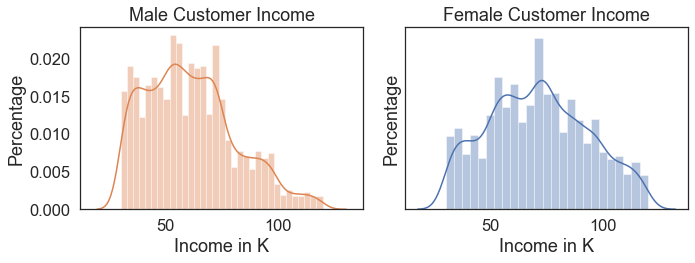

In [68]:
male_customers = profile[profile['gender'] == 1]
female_customers = profile[profile['gender'] == 0]

current_palette = sns.color_palette()

sns.set(font_scale=1.5)
sns.set_style('white')

fig, ax = plt.subplots(figsize=(10, 4),
                       nrows=1,
                       ncols=2,
                       sharex=True,
                       sharey=True)

plt.sca(ax[0])
sns.distplot(male_customers['income'] / 1000,
             color=current_palette[1])
plt.xlabel('Income in K')
plt.ylabel('Percentage')
plt.title('Male Customer Income')

plt.sca(ax[1])
sns.distplot(female_customers['income'] / 1000,
             color=current_palette[0])
plt.xlabel('Income in K')
plt.ylabel('Percentage')
plt.title('Female Customer Income')
plt.tight_layout()

#### Evaluate Membership Start Year Statistics
The results suggest that most customers recently joined the Starbucks rewards program. These results also suggest that there are more male customers than female customers.

In [69]:
def reverse_ohe(dataframe_row,
                is_ohe_column):
    """ Reverses categorical one hot encoding

    INPUT:
        dataframe_row: Pandas Series that stores a DataFrame row

        is_ohe_column: List that describes which DataFrame columns
                       correspond to the one hot encoding of a 
                       categorical variable

    OUTPUT:
        categorical_variable: String that stores the value of a
                              categorical variable"""
    column_idx = np.argwhere(dataframe_row[is_ohe_column])

    return str(dataframe_row.index.values[is_ohe_column][column_idx][0,0])

In [70]:
def initialize_membership_date(profile,
                               gender_integer_map):
    """ Initializes a DataFrame that describes the membership start year
        statistics as a function of customer gender

        INPUT:
            profile: DataFrame that stores customer profiles

            gender_integer_map: Dictionary that describes the mapping of a
                                gender string to an integer

        OUTPUT:
            membership_date: DataFrame that describes the membership start
                             year statistics as a function of customer 
                             gender"""
    is_ohe_column = [type(elem) == int for elem in profile.columns]

    membership_date = profile[['gender']].copy()

    membership_date['gender'] = genderint_to_string(membership_date,
                                                    gender_integer_map)

    membership_date['startyear'] =profile.apply(lambda elem: reverse_ohe(elem, is_ohe_column), axis=1)

    membership_date = membership_date.groupby(['startyear', 'gender']).size()

    membership_date = membership_date.reset_index()

    membership_date.columns = ['startyear', 'gender', 'count']
    
    return membership_date

In [71]:
def genderint_to_string(dataframe,
                        gender_integer_map):
    """Transforms gender encoded as an integer to a string

    INPUT:
        dataframe: DataFrame that includes gender encoded as an integer

        gender_integer_map: Dictionary that describes the mapping of a
                            gender string to an integer

    OUTPUT:
        gender: Series that encodes gender as a string"""
    gender = ['Male' if elem == 'M' else 'Female'
              for elem in gender_integer_map.keys()]

    integer_gender_map = dict(zip(gender_integer_map.values(), gender))

    h_transfrom = lambda elem: integer_gender_map[elem]

    return dataframe['gender'].apply(h_transfrom)


C:\Users\as10755\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


Text(0, 0.5, 'Count')

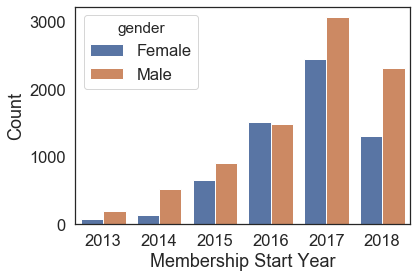

In [72]:
membership_date = initialize_membership_date(profile,
                                             gender_integer_map)

sns.barplot(x='startyear', y='count', hue='gender', data=membership_date)
plt.xlabel('Membership Start Year')
plt.ylabel('Count')

#### Compute customer gender distribution

In [73]:
membership_date.groupby('gender')['count'].sum()

gender
Female    6129
Male      8484
Name: count, dtype: int64

#### Evaluate Age Range Statistics  
These results suggest that the average customer age is between 50 and 60 years old.  


In [74]:
def init_agerange(profile,
                  gender_integer_map):
    """ Initializes a DataFrame that describes a customer's age range as 
    a function of gender
    
    INPUT:
        profile: DataFrame that stores customer profiles

        gender_integer_map: Dictionary that describes the mapping of a
                            gender string to an integer

    OUTPUT:
        age_range: DataFrame that describes a customer's age range as a
                   function of gender
    """
    pattern_obj = re.compile('^\[[0-9]+, [0-9]+\)')

    is_ohe_column =\
        [pattern_obj.match(str(elem)) != None for elem in profile.columns]

    age_range = profile[['gender']].copy()
    age_range['gender'] = genderint_to_string(age_range,
                                            gender_integer_map)

    age_range['agerange'] =\
        profile.apply(lambda elem: reverse_ohe(elem, is_ohe_column), axis=1)

    age_range = age_range.groupby(['agerange', 'gender']).size()

    age_range = age_range.reset_index()

    age_range.columns = ['agerange', 'gender', 'count']

    is_above_100 = re.compile('\[10[0-9]+.*')
    h_transform = lambda elem: is_above_100.match(elem) != None
    above_100 = age_range['agerange'].apply(h_transform)

    return pd.concat([age_range[above_100 == False], age_range[above_100]])


C:\Users\as10755\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

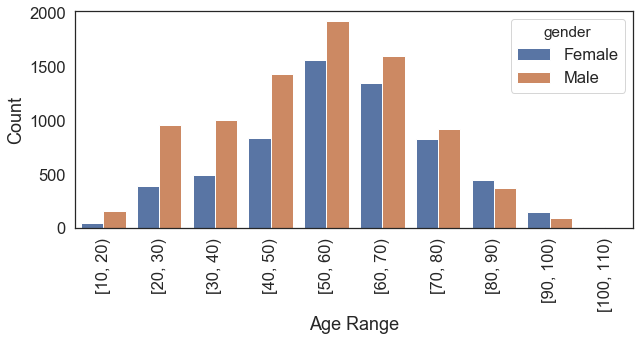

In [75]:
age_range = init_agerange(profile,
                          gender_integer_map)

plt.figure(figsize=(10, 4))
sns.barplot(x='agerange', y='count', hue='gender', data=age_range)
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=90)

## Transaction data EDA
- Customer transaction record attributes
    * event (str) - Record description (i.e. transaction, offer received, offer viewed, etc.)
    * person (str) - Customer id
    * time (int) - Time in hours. The data begins at time t=0
    * value - (dict of strings) - Either an offer id or transaction amount depending on the record
- Customer transaction data EDA conclusions  
    - Need to separate offer and customer purchase data  
    - Results suggest ~ 45 % of the events are customers purchases and ~ 55% of the events describe customer offers  

### Print the first five rows of the transaction data

In [76]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### Compute the event type distribution

In [77]:
event_counts = transcript['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


#### Compute the percentage of customer transaction and offer events

In [78]:
total_transactions = event_counts['count'].sum()

percentage_transactions = 100 * event_counts.iloc[0]['count'] / total_transactions
percentage_offers = 100 * event_counts.iloc[1:]['count'].sum() / total_transactions

print("Percentage of customer transaction events: %.1f %%" % (percentage_transactions))
print("Percentage of customer offer events: %.1f %%" % (percentage_offers))

Percentage of customer transaction events: 45.3 %
Percentage of customer offer events: 54.7 %


### Clean the transaction data  
1. Change the name of the 'person' column to 'customerid'  
2. Remove customer id's that are not in the customer profile DataFrame  
3. Convert time variable units from hours to days  
4. Change the name of the 'time' column to 'timedays'  
5. Create a DataFrame that describes offers  
    - Create an offerid column
    - Parse the offer event type (i.e. 'received', 'viewed', or 'completed')
    - One hot encode customer offer events 
6. Create a DataFrame that describes customer transaction events
    - Parse customer transaction values  

In [85]:
def clean_transcript(profile,
                     data_dir = './data'):
    """ Transforms a DataFrame that contains records for transactions, offers
    received, offers viewed, and offers completed

    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer

        (Optional) data_dir: String that stores the full path to the
                             data directory

    OUTPUT:
        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions
    """
    transcript = pd.read_json(os.path.join(data_dir,
                                           'transcript.json'),
                              orient='records',
                              lines=True)

    # Change the name of the 'person' column to 'customerid'
    transcript.columns = update_column_name(transcript,
                                            'person',
                                            'customerid')

    # Remove customer id's that are not in the customer profile DataFrame
    select_data = transcript['customerid'].isin(profile['customerid'])
    transcript = transcript[select_data]

    percent_removed = 100 * (1 - select_data.sum() / select_data.shape[0])
    print("Percentage of transactions removed: %.2f %%" % percent_removed)

    # Convert from hours to days
    transcript['time'] /= 24.0
    
    # Change the name of the 'time' column to 'timedays'
    transcript.columns = update_column_name(transcript,'time','timedays')

    # Select customer offers
    pattern_obj = re.compile('^offer (?:received|viewed|completed)')

    h_is_offer = lambda elem: pattern_obj.match(elem) != None

    is_offer = transcript['event'].apply(h_is_offer)

    offer_data = transcript[is_offer].copy()
    offer_data = offer_data.reset_index(drop=True)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_order = ['offerid', 'customerid', 'timedays']

    # Create an offerid column
    offer_data['offerid'] = offer_data['value'].apply(lambda elem: list(elem.values())[0])

    # Transform a column that describes a customer offer event
    pattern_obj = re.compile('^offer ([a-z]+$)')

    h_transform = lambda elem: pattern_obj.match(elem).groups(1)[0]

    offer_data['event'] = offer_data['event'].apply(h_transform)

    # One hot encode customer offer events
    event_df = pd.get_dummies(offer_data['event'])
    column_order.extend(event_df.columns.values)

    # Create a DataFrame that describes customer offer events
    offer_data = pd.concat([offer_data, event_df], axis=1)
    offer_data.drop(columns=['event', 'value'])
    offer_data = offer_data[column_order]

    # Select customer transaction events
    transaction = transcript[is_offer == False]
    transaction = transaction.reset_index(drop=True)

    # Transform customer transaction event values
    transaction['amount'] = transaction['value'].apply(lambda elem: list(elem.values())[0])

    # Create a DataFrame that describes customer transactions
    transaction = transaction.drop(columns=['event', 'value'])
    column_order = ['customerid', 'timedays', 'amount']
    transaction = transaction[column_order]

    return offer_data, transaction


In [86]:
offer_data, transaction = clean_transcript(profile)

Percentage of transactions removed: 12.31 %


#### Print the first five rows of the transformed customer offer data

In [87]:
offer_data.head()

,offerid,customerid,timedays,completed,received,viewed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0.0,0,1,0
1,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0.0,0,1,0
2,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,0.0,0,1,0
3,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d,0.0,0,1,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e1,0.0,0,1,0


#### Print the first five rows of the transformed customer transaction data

In [88]:
transaction.head()

,customerid,timedays,amount
0,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
1,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
2,54890f68699049c2a04d415abc25e717,0.0,13.23
3,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
4,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


# Combining transaction, demographic and offer data 
For each customer, apply the following algorithm:
1. Select a customer's profile  
2. Select offer data for a specific customer
3. Select transactions for a specific customer
4. Initialize DataFrames that describe when a customer receives, views, and completes an offer
5. Iterate over each offer a customer receives
    - Initialize the current offer id  
    - Look-up a description of the current offer  
    - Initialize the time period when an offer is valid
    - Initialize a Boolean array that select customer transactions that fall within the valid offer time window
    - Initialize a Boolean array that selects a description of when a customer completes an offer (this array may not contain any True values)  
    - Initialize a Boolean array that selects a description of when a customer views an offer (this array may not contain any True values)
    - Determine whether the current offer was successful
        - For an offer to be successful a customer has to view and complete it  
    - Select customer transactions that occurred within the current offer valid time window  
    - Initialize a dictionary that describes the current customer offer  
    - Update a list of dictionaries that describes the effectiveness of offers to a specific customer
   
Once all customer transactions have been evaluated, convert the resulting list of dictionaries into a pandas DataFrame.

In [95]:
def create_offeranalysis_dataset(profile,
                                 portfolio,
                                 offer_data,
                                 transaction):
    """ Creates an analytic dataset from the following Starbucks challenge 
    datasets:

    * portfolio.json - Contains offer ids and meta data (duration, type,
                       etc.)

    * profile.json - demographic data for each customer

    * transcript.json - records for transactions, offers received, offers
                        viewed, and offers completed
                        
    INPUT:
        profile: DataFrame that contains demographic data for each 
                 customer

        portfolio: Contains offer ids and meta data (duration, type, etc.)

        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions

    OUTPUT:
        clean_data: DataFrame that characterizes the effectiveness of
                    customer offers"""
    clean_data = []
    customerid_list = offer_data['customerid'].unique()

    widgets=[' [',
             progressbar.Timer(), '] ',
             progressbar.Bar(),
             ' (',
             progressbar.ETA(),
             ') ']

    for idx in progressbar.progressbar(range(len(customerid_list)),
                                       widgets=widgets):

        clean_data.extend(create_combined_records(customerid_list[idx],
                                                  portfolio,
                                                  profile,
                                                  offer_data,
                                                  transaction))

    clean_data = pd.DataFrame(clean_data)

    # Initialize a list that describes the desired output DataFrame
    # column ordering
    column_ordering = ['time', 'offerid', 'customerid', 'totalamount',
                       'offersuccessful', 'difficulty', 'durationdays',
                       'reward', 'bogo', 'discount', 'informational',
                       'email', 'mobile', 'social', 'web', 'gender',
                       'income', 2013, 2014, 2015, 2016, 2017, 2018,
                       '[10, 20)', '[20, 30)', '[30, 40)', '[40, 50)',
                       '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)',
                       '[90, 100)', '[100, 110)']

    clean_data = clean_data[column_ordering]

    clean_data = clean_data.sort_values('time')
    return clean_data.reset_index(drop=True)


In [98]:
def create_combined_records(customer_id,
                            portfolio,
                            profile,
                            offer_data,
                            transaction):
    """ 
    Creates a list of dictionaries that describes the effectiveness of
    offers to a specific customer

    INPUT:
        customer_id: String that refers to a specific customer

        profile: DataFrame that contains demographic data for each 
                 customer
                 
        portfolio: DataFrame containing offer ids and meta data about 
                   each offer (duration, type, etc.)

        offer_data: DataFrame that describes customer offer data

        transaction: DataFrame that describes customer transactions
    
    OUTPUT:
        rows: List of dictionaries that describes the effectiveness of
              offers to a specific customer
    """
    # Select a customer's profile
    cur_customer = profile[profile['customerid'] == customer_id]

    # Select offer data for a specific customer
    select_offer_data = offer_data['customerid'] == customer_id
    customer_offer_data = offer_data[select_offer_data]
    customer_offer_data = customer_offer_data.drop(columns='customerid')
    customer_offer_data = customer_offer_data.reset_index(drop=True)

    # Select transactions for a specific customer
    select_transaction = transaction['customerid'] == customer_id
    customer_transaction_data = transaction[select_transaction]

    customer_transaction_data =\
        customer_transaction_data.drop(columns='customerid')

    customer_transaction_data =\
        customer_transaction_data.reset_index(drop=True)

    # Initialize DataFrames that describe when a customer receives,
    # views, and completes an offer
    event_type = ['completed',
                  'received',
                  'viewed']

    offer_received =\
        customer_offer_data[customer_offer_data['received'] == 1]

    offer_received = offer_received.drop(columns=event_type)
    offer_received = offer_received.reset_index(drop=True)

    offer_viewed =\
        customer_offer_data[customer_offer_data['viewed'] == 1]

    offer_viewed = offer_viewed.drop(columns=event_type)
    offer_viewed = offer_viewed.reset_index(drop=True)

    offer_completed =\
        customer_offer_data[customer_offer_data['completed'] == 1]

    offer_completed = offer_completed.drop(columns=event_type)
    offer_completed = offer_completed.reset_index(drop=True)

    # Iterate over each offer a customer receives
    rows = []
    for idx in range(offer_received.shape[0]):

        # Initialize the current offer id
        cur_offer_id = offer_received.iloc[idx]['offerid']

        # Look-up a description of the current offer
        cur_offer = portfolio.loc[portfolio['offerid'] == cur_offer_id]
        durationdays = cur_offer['durationdays'].values[0]

        # Initialize the time period when an offer is valid
        cur_offer_startime = offer_received.iloc[idx]['timedays']

        cur_offer_endtime =\
            offer_received.iloc[idx]['timedays'] + durationdays

        # Initialize a boolean array that select customer transcations that
        # fall within the valid offer time window
        select_transaction =\
            np.logical_and(customer_transaction_data['timedays'] >=
                           cur_offer_startime,
                           customer_transaction_data['timedays'] <=
                           cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer completes an offer (this array may not contain any True
        # values)
        select_offer_completed =\
            np.logical_and(offer_completed['timedays'] >= cur_offer_startime,
                           offer_completed['timedays'] <= cur_offer_endtime)

        # Initialize a boolean array that selects a description of when a
        # customer views an offer (this array may not contain any True
        # values)
        select_offer_viewed =\
            np.logical_and(offer_viewed['timedays'] >= cur_offer_startime,
                           offer_viewed['timedays'] <= cur_offer_endtime)

        # Determine whether the current offer was successful
        cur_offer_successful =\
            select_offer_completed.sum() > 0 and select_offer_viewed.sum() > 0

        # Select customer transcations that occurred within the current offer
        # valid time window
        cur_offer_transactions = customer_transaction_data[select_transaction]

        # Initialize a dictionary that describes the current customer offer
        cur_row = {'offerid': cur_offer_id,
                   'customerid': customer_id,
                   'time': cur_offer_startime,
                   'offersuccessful': int(cur_offer_successful),
                   'totalamount': cur_offer_transactions['amount'].sum()}

        cur_row.update(cur_offer.iloc[0,1:].to_dict())

        cur_row.update(cur_customer.iloc[0,1:].to_dict())

        # Update a list of dictionaries that describes the effectiveness of 
        # offers to a specific customer
        rows.append(cur_row)

    return rows

In [99]:
clean_data_csvfile = "./data/clean_data.csv"

if os.path.exists(clean_data_csvfile):
    clean_data = pd.read_csv(clean_data_csvfile)
else:
    clean_data = create_offeranalysis_dataset(profile,
                                              portfolio,
                                              offer_data,
                                              transaction)

    clean_data.to_csv(clean_data_csvfile, index=False)
    
clean_data = clean_data.drop(columns=['time',
                                      'customerid',
                                      'email',
                                      'informational'])

column_ordering = ['offerid', 'totalamount']
column_ordering.extend([elem for elem in clean_data.columns if elem not in column_ordering])

clean_data = clean_data[column_ordering]
clean_data.head()

 [Elapsed Time: 0:10:51] |##################################| (Time:  0:10:51) 


,offerid,totalamount,offersuccessful,difficulty,durationdays,reward,bogo,discount,mobile,social,...,"[10, 20)","[20, 30)","[30, 40)","[40, 50)","[50, 60)","[60, 70)","[70, 80)","[80, 90)","[90, 100)","[100, 110)"
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,37.67,1,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,48.31,1,10,5,10,1,0,1,1,...,0,0,0,0,1,0,0,0,0,0
2,5a8bc65990b245e5a138643cd4eb9837,23.43,0,0,3,0,0,0,1,1,...,0,0,0,1,0,0,0,0,0,0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,52.24,0,5,7,5,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,fafdcd668e3743c1bb461111dcafc2a4,5.12,0,10,10,2,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


In [104]:
clean_data.columns

Index([        'offerid',     'totalamount', 'offersuccessful',
            'difficulty',    'durationdays',          'reward',
                  'bogo',        'discount',          'mobile',
                'social',             'web',          'gender',
                'income',              2013,              2014,
                    2015,              2016,              2017,
                    2018,        '[10, 20)',        '[20, 30)',
              '[30, 40)',        '[40, 50)',        '[50, 60)',
              '[60, 70)',        '[70, 80)',        '[80, 90)',
             '[90, 100)',      '[100, 110)'],
      dtype='object')

# Spliting the data into training and testing data


In [101]:
random_state = 0

class_label_name = 'offersuccessful'

variables = clean_data.drop(columns=[class_label_name])
class_label = clean_data.filter([class_label_name])

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(variables.values,
                            class_label.values,
                            test_size=0.2,
                            random_state=random_state)

variable_names = variables.columns[2:]

offerid_train = X_train[:, 0]
totalamount_train = X_train[:, 1]
X_train = X_train[:, 2:].astype('float64')

offerid_test = X_test[:, 0]
totalamount_test = X_test[:, 1]
X_test = X_test[:, 2:].astype('float64')

y_train = y_train.ravel()
y_test = y_test.ravel()

## Data attributes

In [102]:
print(variable_names)

Index([  'difficulty', 'durationdays',       'reward',         'bogo',
           'discount',       'mobile',       'social',          'web',
             'gender',       'income',           2013,           2014,
                 2015,           2016,           2017,           2018,
           '[10, 20)',     '[20, 30)',     '[30, 40)',     '[40, 50)',
           '[50, 60)',     '[60, 70)',     '[70, 80)',     '[80, 90)',
          '[90, 100)',   '[100, 110)'],
      dtype='object')


# Predictive Modeling

## Evaluate naive predictor performance

In [106]:
naive_predictor_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_predictor_f1score = f1_score(y_train, np.ones(len(y_train)))

print("Naive predictor accuracy: %.3f" % (naive_predictor_accuracy))
print("Naive predictor f1-score: %.3f" % (naive_predictor_f1score))

Naive predictor accuracy: 0.469
Naive predictor f1-score: 0.638


## Constructing Logistic Regression model

- Results suggest that a logistic regression model's accuracy and f1-score is better than the naive predictor
    - Accuracy
        - Naive predictor: 0.471
        - Logistic regression: 0.722
    - F1-score
        - Naive predictor: 0.640
        - Logistic regression: 0.716

In [107]:
model_dir = "./models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
lr_model_path = os.path.join(model_dir, 'lr_clf.joblib')

scorer = make_scorer(fbeta_score,
                     beta=0.5)

if os.path.exists(lr_model_path):
    lr_random = load(lr_model_path)
else:
    lr_clf = LogisticRegression(random_state=random_state,
                                solver='liblinear')

    random_grid = {'penalty': ['l1', 'l2'],
                   'C': [1.0, 0.1, 0.01]}

    lr_random = RandomizedSearchCV(estimator = lr_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 6,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    lr_random.fit(X_train, y_train)

    dump(lr_random, lr_model_path)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    5.3s finished


#### Define model performance evaluation function

In [108]:
def evaluate_model_performance(clf,
                               X_train,
                               y_train):
    """ Prints a model's accuracy and F1-score
    
    INPUT:
        clf: Model object
        
        X_train: Training data matrix

        y_train: Expected model output vector
    
    OUTPUT:
        clf_accuracy: Model accuracy
        
        clf_f1_score: Model F1-score"""
    class_name = re.sub("[<>']", '', str(clf.__class__))
    class_name = class_name.split(' ')[1]
    class_name = class_name.split('.')[-1]

    y_pred_rf = clf.predict(X_train)

    clf_accuracy = accuracy_score(y_train, y_pred_rf)
    clf_f1_score = f1_score(y_train, y_pred_rf)
    
    print("%s model accuracy: %.3f" % (class_name, clf_accuracy))
    print("%s model f1-score: %.3f" % (class_name, clf_f1_score))
    
    return clf_accuracy, clf_f1_score

#### Evaluate Logistic Regression Model Performance

In [109]:
evaluate_model_performance(lr_random.best_estimator_,
                           X_train,
                           y_train)

LogisticRegression model accuracy: 0.723
LogisticRegression model f1-score: 0.716


(0.7232027140352215, 0.7159315403422983)

## Construct Random Forest Model
- Resuls suggest that a random forest model's accuracy and f1-score is better than the naive predictor
    - Accuracy
        - Naive predictor: 0.471
        - Random forest: 0.742
    - F1-score
        - Naive predictor: 0.640
        - Random forest: 0.735

In [110]:
rf_model_path = os.path.join(model_dir, 'rf_clf.joblib')

if os.path.exists(rf_model_path):
    rf_random = load(rf_model_path)
else:
    rf_clf = RandomForestClassifier(random_state=random_state)

    # Number of trees in random forest
    n_estimators = [10, 30, 50, 100, 150, 200, 250, 300]

    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']

    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.arange(3, 11)]
    max_depth.append(None)

    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]

    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(estimator = rf_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    rf_random.fit(X_train, y_train)
    
    dump(rf_random, rf_model_path)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   34.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  4.5min finished


### Evalaute Random Forest Model Performance

In [111]:
evaluate_model_performance(rf_random.best_estimator_,
                           X_train,
                           y_train)

RandomForestClassifier model accuracy: 0.743
RandomForestClassifier model f1-score: 0.735


(0.7431767934741176, 0.7346134908911867)

### Plot Estimated Feature Importance
- Feature importance refers to a numerical value that describes a feature's contribution to building a model that maximizes its evaluation metric   
- These results suggest that the top five features for this problem are:
    1. Offer difficulty (how much money a customer must spend to complete an offer)
    2. Offer duration
    3. Offer reward
    4. Customer income
    5. Whether a customer created an account on the Starbucks rewards mobile application in 2018  

Text(0.5, 1.0, 'Random Forest Estimated Feature Importance')

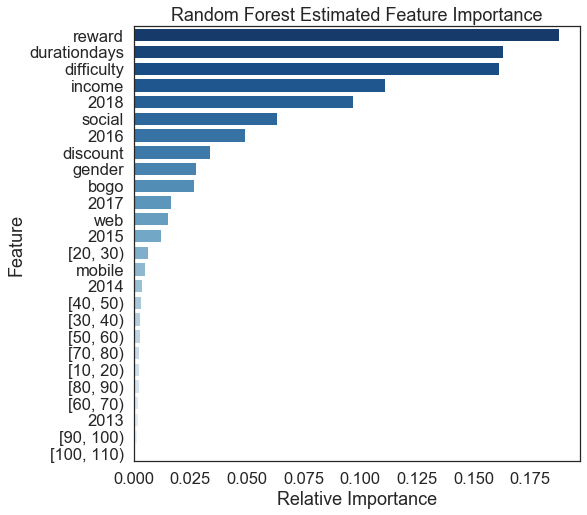

In [112]:
relative_importance = rf_random.best_estimator_.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.title('Random Forest Estimated Feature Importance')

#### Print the top 10 features sorted based on their estimated importance

In [113]:
feature_importance.head(n=10)

,feature,relativeimportance
0,reward,0.187650
1,durationdays,0.163017
2,difficulty,0.161152
3,income,0.111017
4,2018,0.097010
5,social,0.063435
6,2016,0.049229
7,discount,0.033663
8,gender,0.027470
9,bogo,0.026463


## Constructing a Gradient Boosting classifier
- Resuls suggest that a gradient boosting model's accuracy and f1-score is better than the naive predictor
    - Accuracy
        - Naive predictor: 0.471
        - Gradient boosting: 0.736
    - F1-score
        - Naive predictor: 0.640
        - Gradient boosting: 0.725

In [114]:
gb_model_path = os.path.join(model_dir, 'gb_clf.joblib')

if os.path.exists(gb_model_path):
    gb_random = load(gb_model_path)
else:
    gb_clf = GradientBoostingClassifier(random_state=random_state)

    # Create the random grid
    random_grid = {'loss': ['deviance', 'exponential'],
                   'learning_rate': [0.1, 0.01, 0.001],
                   'n_estimators': [10, 30, 50, 100, 150, 200, 250, 300],
                   'min_samples_leaf': min_samples_leaf,
                   'min_samples_split': min_samples_split}

    gb_random = RandomizedSearchCV(estimator = gb_clf,
                                   param_distributions = random_grid,
                                   scoring=scorer,
                                   n_iter = 100,
                                   cv = 3,
                                   verbose=2,
                                   random_state=random_state,
                                   n_jobs = 3)

    gb_random.fit(X_train, y_train)

    dump(gb_random, gb_model_path)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  7.0min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed: 12.9min finished


### Evaluate Gradient Boosting Model Performance

In [115]:
evaluate_model_performance(gb_random.best_estimator_,
                           X_train,
                           y_train)

GradientBoostingClassifier model accuracy: 0.735
GradientBoostingClassifier model f1-score: 0.723


(0.7351909735457803, 0.7229400973119566)

# Tune the best model
- Model ranking based on training data accuracy
    1. RandomForestClassifier model accuracy: 0.742
    2. GradientBoostingClassifier model accuracy: 0.736
    3. LogisticRegression model accuracy: 0.722
    4. Naive predictor accuracy: 0.471
- Model ranking based on training data F1-score
    1. RandomForestClassifier model f1-score: 0.735
    2. GradientBoostingClassifier model f1-score: 0.725
    3. LogisticRegression model f1-score: 0.716
    4. Naive predictor f1-score: 0.640
- Results suggest that the random forest model has the best training data accuracy and F1-score  

A logistic regression model constructs a linear decision boundary to separate successful and unsuccessful offers. However, based on the exploratory analysis the decision boundary could be non-linear. Therefore, an ensemble method like random forest or gradient boosting should perform better.
Both random forest and gradient boosting models are a combination of multiple decision trees. A random forest classifier randomly samples the training data with replacement to construct a set of decision trees that are combined using majority voting. In contrast, gradient boosting iteratively constructs a set of decision trees with the goal of reducing the number of misclassified training data samples from the previous iteration. A consequence of these model construction strategies is that the depth of decision trees generated during random forest model training are typically greater than gradient boosting weak learner depth to minimize model variance. Typically, gradient boosting performs better than a random forest classifier. However, gradient boosting may overfit the training data and requires additional effort to tune. A random forest classifier is less prone to overfitting because it constructs decision trees from random training data samples. Also, a random forest classifier’s hyperparameters are easier to optimize.

Link - https://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics & https://www.quora.com/How-can-the-performance-of-a-Gradient-Boosting-Machine-be-worse-than-Random-Forests

In [116]:
model_performance = []

classifier_type = ['naivepredictor',
                   'logisticregression',
                   'randomforest',
                   'gradientboosting']

model_performance.append((naive_predictor_accuracy,
                          naive_predictor_f1score))

model_performance.append(evaluate_model_performance(lr_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(rf_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance.append(evaluate_model_performance(gb_random.best_estimator_,
                                                    X_train,
                                                    y_train))

model_performance = pd.DataFrame(model_performance,
                                 columns=['accuracy', 'f1score'])

classifier_type = pd.DataFrame(classifier_type,
                               columns=['classifiertype'])

model_performance = pd.concat([classifier_type, model_performance],
                              axis=1)

model_performance = model_performance.sort_values('accuracy', ascending=False)
model_performance = model_performance.reset_index(drop=True)
model_performance

LogisticRegression model accuracy: 0.723
LogisticRegression model f1-score: 0.716
RandomForestClassifier model accuracy: 0.743
RandomForestClassifier model f1-score: 0.735
GradientBoostingClassifier model accuracy: 0.735
GradientBoostingClassifier model f1-score: 0.723


,classifiertype,accuracy,f1score
0,randomforest,0.743177,0.734613
1,gradientboosting,0.735191,0.722940
2,logisticregression,0.723203,0.715932
3,naivepredictor,0.468800,0.638344


## Print the Best Model's Hyperparameters

In [117]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


## Refine Best Model
- Refine model hyperparameter space
    - [Hyperparameter Tuning the Random Forest in Python](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)  

In [118]:
grid_fit_path = os.path.join(model_dir, 'grid_fit.joblib')

if os.path.exists(grid_fit_path):
    grid_fit = load(grid_fit_path)
else:
    parameters = {'n_estimators': [300, 350, 400, 450, 500],
                  'max_depth': [10, 11, 12, 13, 14, 15],
                  'min_samples_leaf': min_samples_leaf,
                  'min_samples_split': min_samples_split,
                  'random_state': [random_state]}

    grid_obj = GridSearchCV(rf_clf,
                            parameters,
                            scoring=scorer,
                            cv=5,
                            n_jobs=3,
                            verbose=2)

    grid_fit = grid_obj.fit(X_train,
                            y_train)

    dump(grid_fit, grid_fit_path)

# Get the estimator
best_clf = grid_fit.best_estimator_

evaluate_model_performance(best_clf,
                           X_train,
                           y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  8.1min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed: 19.0min
[Parallel(n_jobs=3)]: Done 642 tasks      | elapsed: 35.1min
[Parallel(n_jobs=3)]: Done 1007 tasks      | elapsed: 57.7min
[Parallel(n_jobs=3)]: Done 1350 out of 1350 | elapsed: 80.5min finished


RandomForestClassifier model accuracy: 0.752
RandomForestClassifier model f1-score: 0.742


(0.7519440420827933, 0.741811978019798)

### Print the Refined Random Forest Model's Hyperparameters

In [119]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Evaluate Test Data Performance

In [120]:
evaluate_model_performance(best_clf,
                           X_test,
                           y_test)

RandomForestClassifier model accuracy: 0.733
RandomForestClassifier model f1-score: 0.727


(0.7331706945185636, 0.7266479225242112)

# Conclusion

The analysis suggests that a random forest model has the best training data accuracy and F1-score. The refined random forest model hyperparameters using a grid search suggests that the resulting random forest model has a training data accuracy of 0.752 and an F1-score of 0.742. The test data set accuracy of 0.733 and F1-score of 0.727 suggests that the random forest model we constructed did not overfit the data.
The top five features based on their importance are:
Reward, duration days, difficulty, income and whether a customer created an account on the Starbucks rewards mobile application in 2018.



# Future improvements

Since the top three features are associated with a customer offer, it may be possible to improve the performance of a random forest model by creating features that describe an offer’s success rate as a function of offer difficulty, duration, and reward. These additional features should provide a random forest classifier the opportunity to construct a better decision boundary that separates successful and unsuccessful customer offers.